<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

<span style="color:red">
    Répondre ci-dessous
</span>

* Nom, prénom
* Nom, prénom
* Nom, prénom

# Présentation du challenge

## La question principale de ce challenge est :

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ?
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital

Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce projet est de travailler sur un challenge de prédiction de la mortalité.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour la qualité de la présentation orale

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module requis : `imblearn` (à installer avec `conda`)

`conda install -c conda-forge imbalanced-learn`

In [1]:
import platform
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [2]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

sns.set_style("darkgrid")
sns.set_context("notebook")

print(pd.__version__)       # 2.0.0
print(sklearn.__version__)  # 1.2.2

2.2.1
1.4.1.post1


## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<span style="color:red">
    Répondre ci-dessous
</span>

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

<span style="color:red">
    Répondre ci-dessous
</span>

## 2. Chargement des données

In [3]:
#DATA = Path(
#    "~/ownCloud/EDU/Courses/L2-ISD2/PRACTICALs/Project/public_data"
#).expanduser()
DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

assert DATA.is_dir()

In [4]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
print(x_df.shape)
x_df.head(20)

(79999, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,75,83.8,89.2,86.1,...,0,0,0,0,0,0,0,0,1,0
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,55,60.9,106,80.6,...,0,0,0,0,0,0,0,0,0,0
5,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,F,66,40,68.4,60.4,...,0,0,0,0,0,0,0,0,0,0
6,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,M,88,56.9,98.8,70.7,...,0,0,0,0,0,0,0,0,1,0
7,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,F,81,62,85.8,84.5,...,0,0,0,0,0,0,1,0,0,0
8,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,M,57,89.7,110,114,...,0,0,0,0,0,0,0,0,0,1
9,Medicare,ENGL,JEWISH,MARRIED,WHITE,M,90,73,102,94.1,...,0,0,0,0,0,0,1,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codabench (les modalités pour la téléversion seront précisées prochainement sur la page du cours eCampus）et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [6]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

print(x_test_df.shape)
x_test_df.head(3)

(20001, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Self_Pay,ENGL,OTHER,MARRIED,WHITE,F,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,F,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,M,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


## 3. Analyse exploratoire

#### Types des variables

In [7]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

0
Numerical      226
Binary         107
Categorical      8
Name: count, dtype: int64

#### Distribution de la variable cible

In [8]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

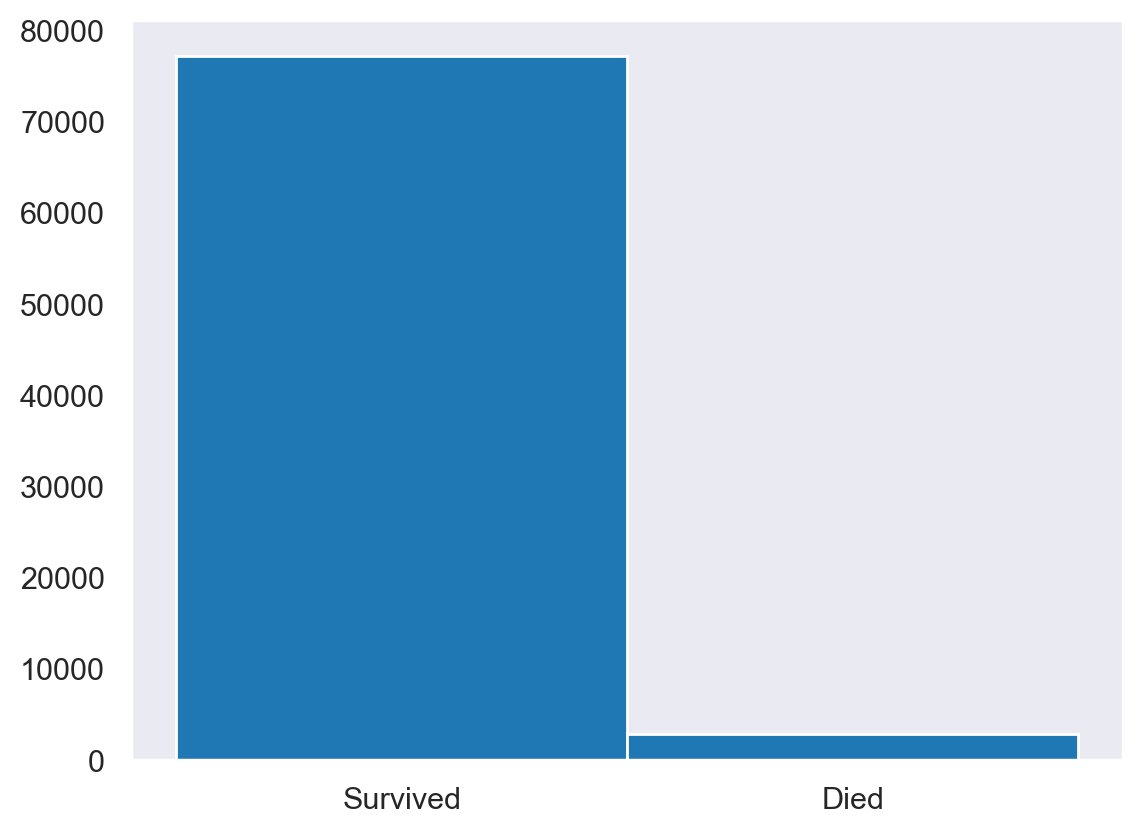

In [9]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

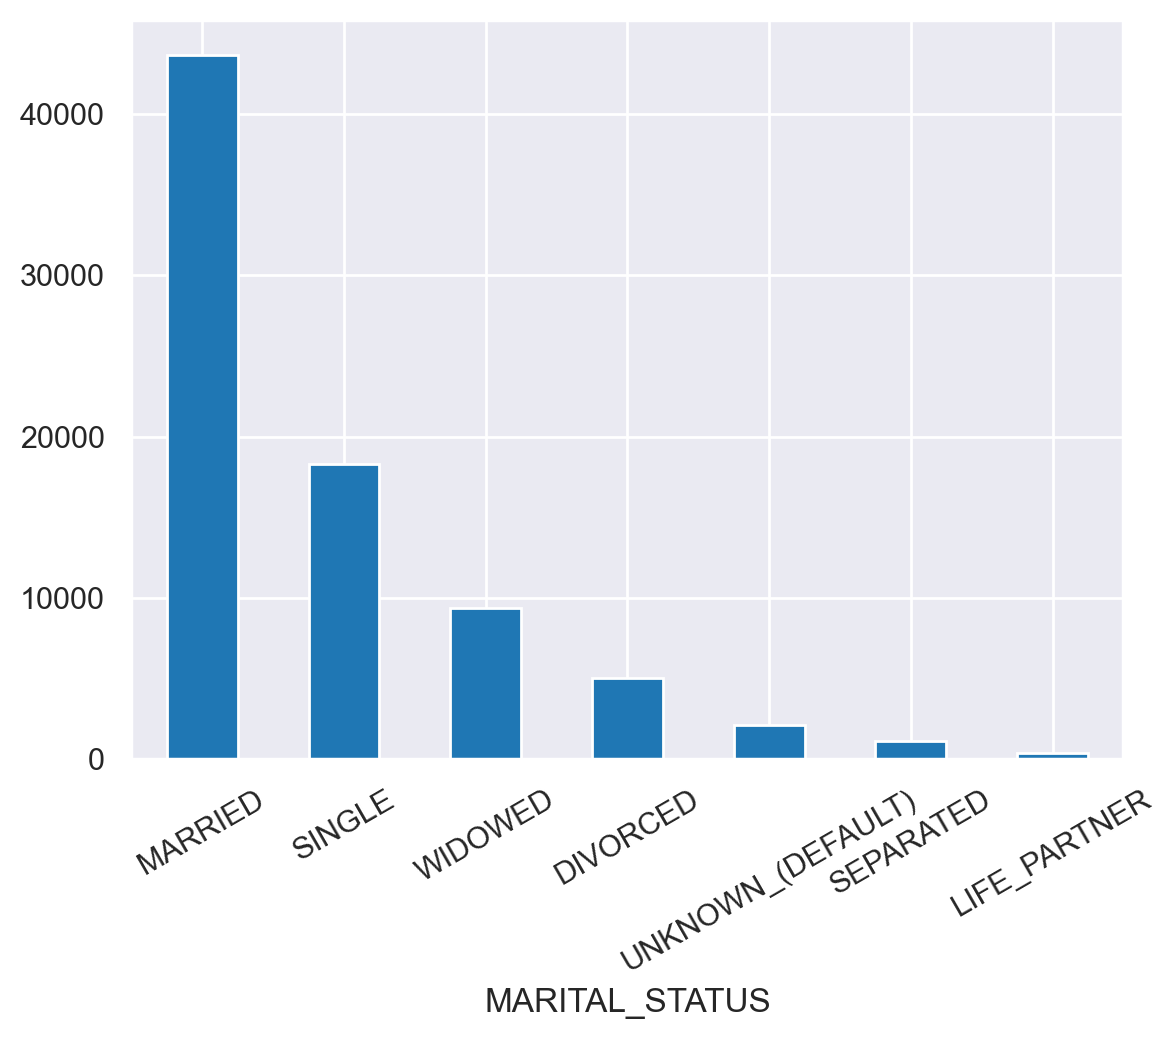

In [10]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

<span style="color:red">
    Répondre ci-dessous
</span>

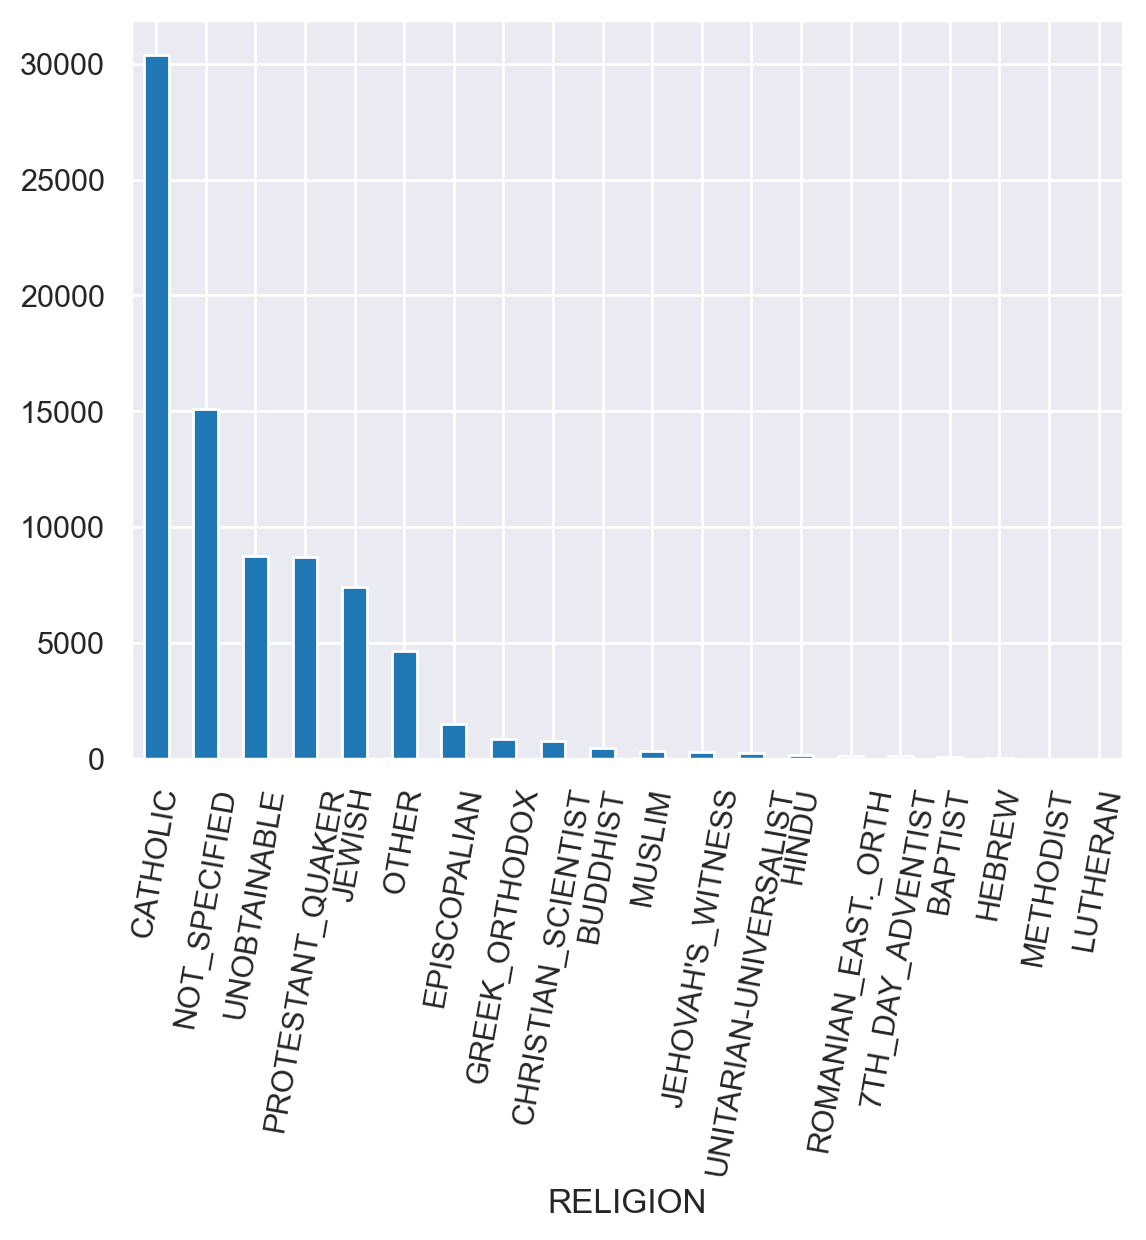

In [11]:
x_religion_cnts = x_df["RELIGION"].value_counts()
x_religion_cnts.plot.bar(rot=80)
plt.show()

#### Corrélations

In [12]:
x_df1 = pd.get_dummies(x_df)
x_df1['Survived'] = ys

In [13]:
correlation_matrix = x_df1.corr()

RESP_RATE_MEAN_DAY1   0.0958
Adltrespfl            0.0908
RESP_RATE_MAX_DAY1    0.0906
RESP_RATE_MEAN_DAY2   0.0894
RESP_RATE_MAX_DAY2    0.0861
                       ...  
SexualInfxs              NaN
Eyeinfectn               NaN
Otitismedia              NaN
Dizziness                NaN
Othereardx               NaN
Name: Survived, Length: 478, dtype: float64


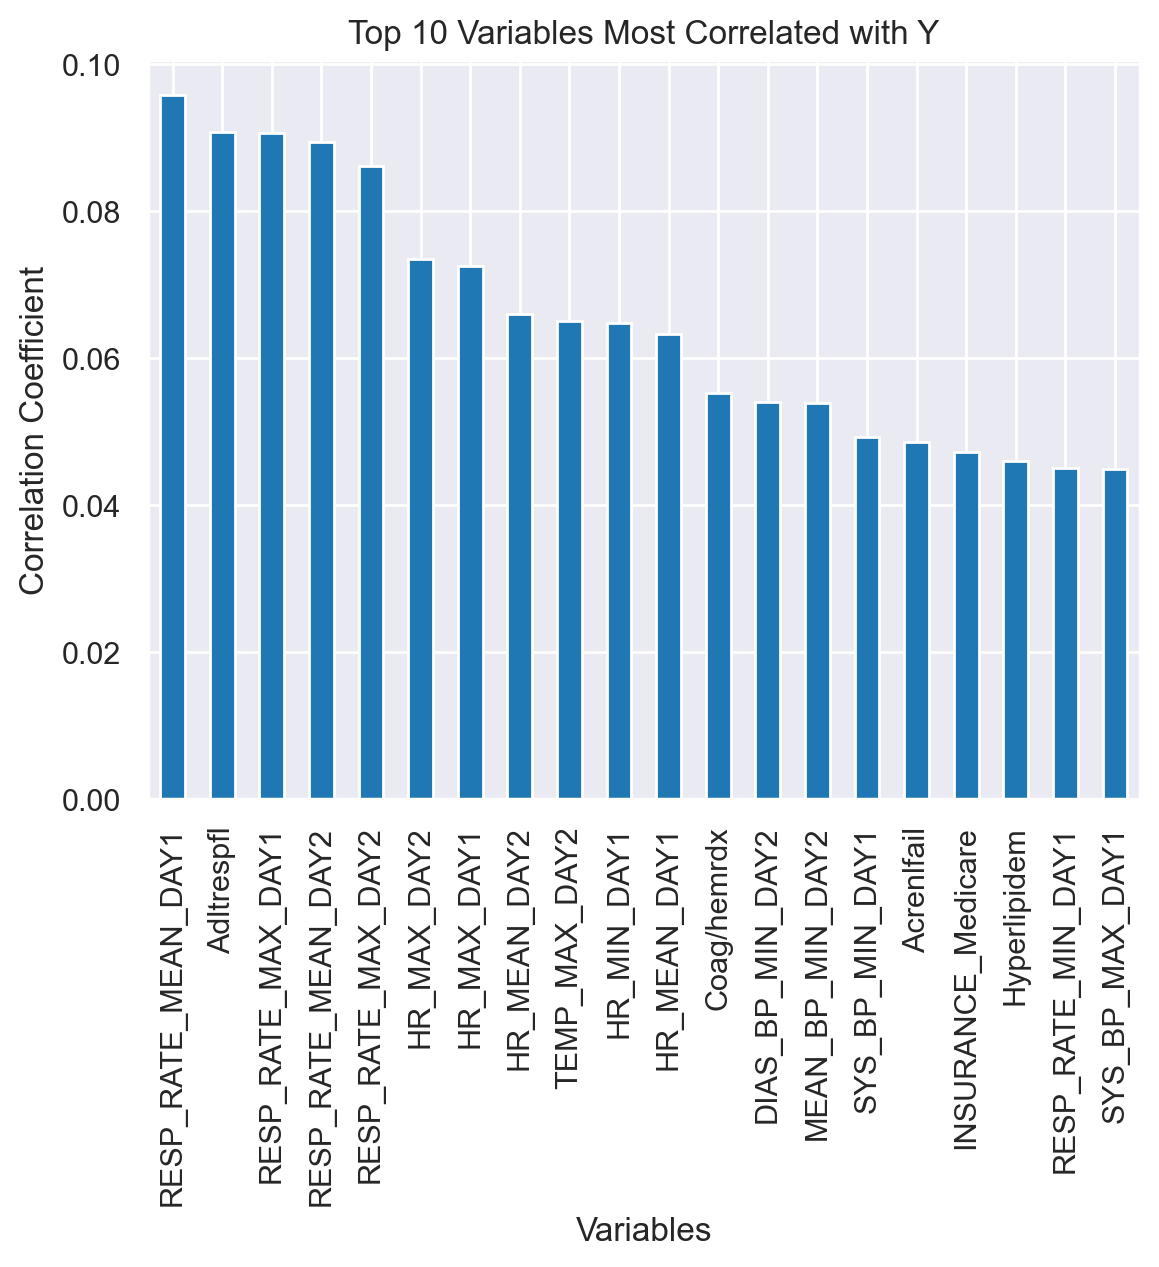

In [14]:
survived_correlations = correlation_matrix['Survived'].drop('Survived').abs()

# Sort correlations by absolute value
sorted_correlations = survived_correlations.sort_values(ascending=False)

# Print or visualize the top correlated variables
print(sorted_correlations)
sorted_correlations.head(20).plot.bar()
plt.title('Top 10 Variables Most Correlated with Y')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.show()

Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

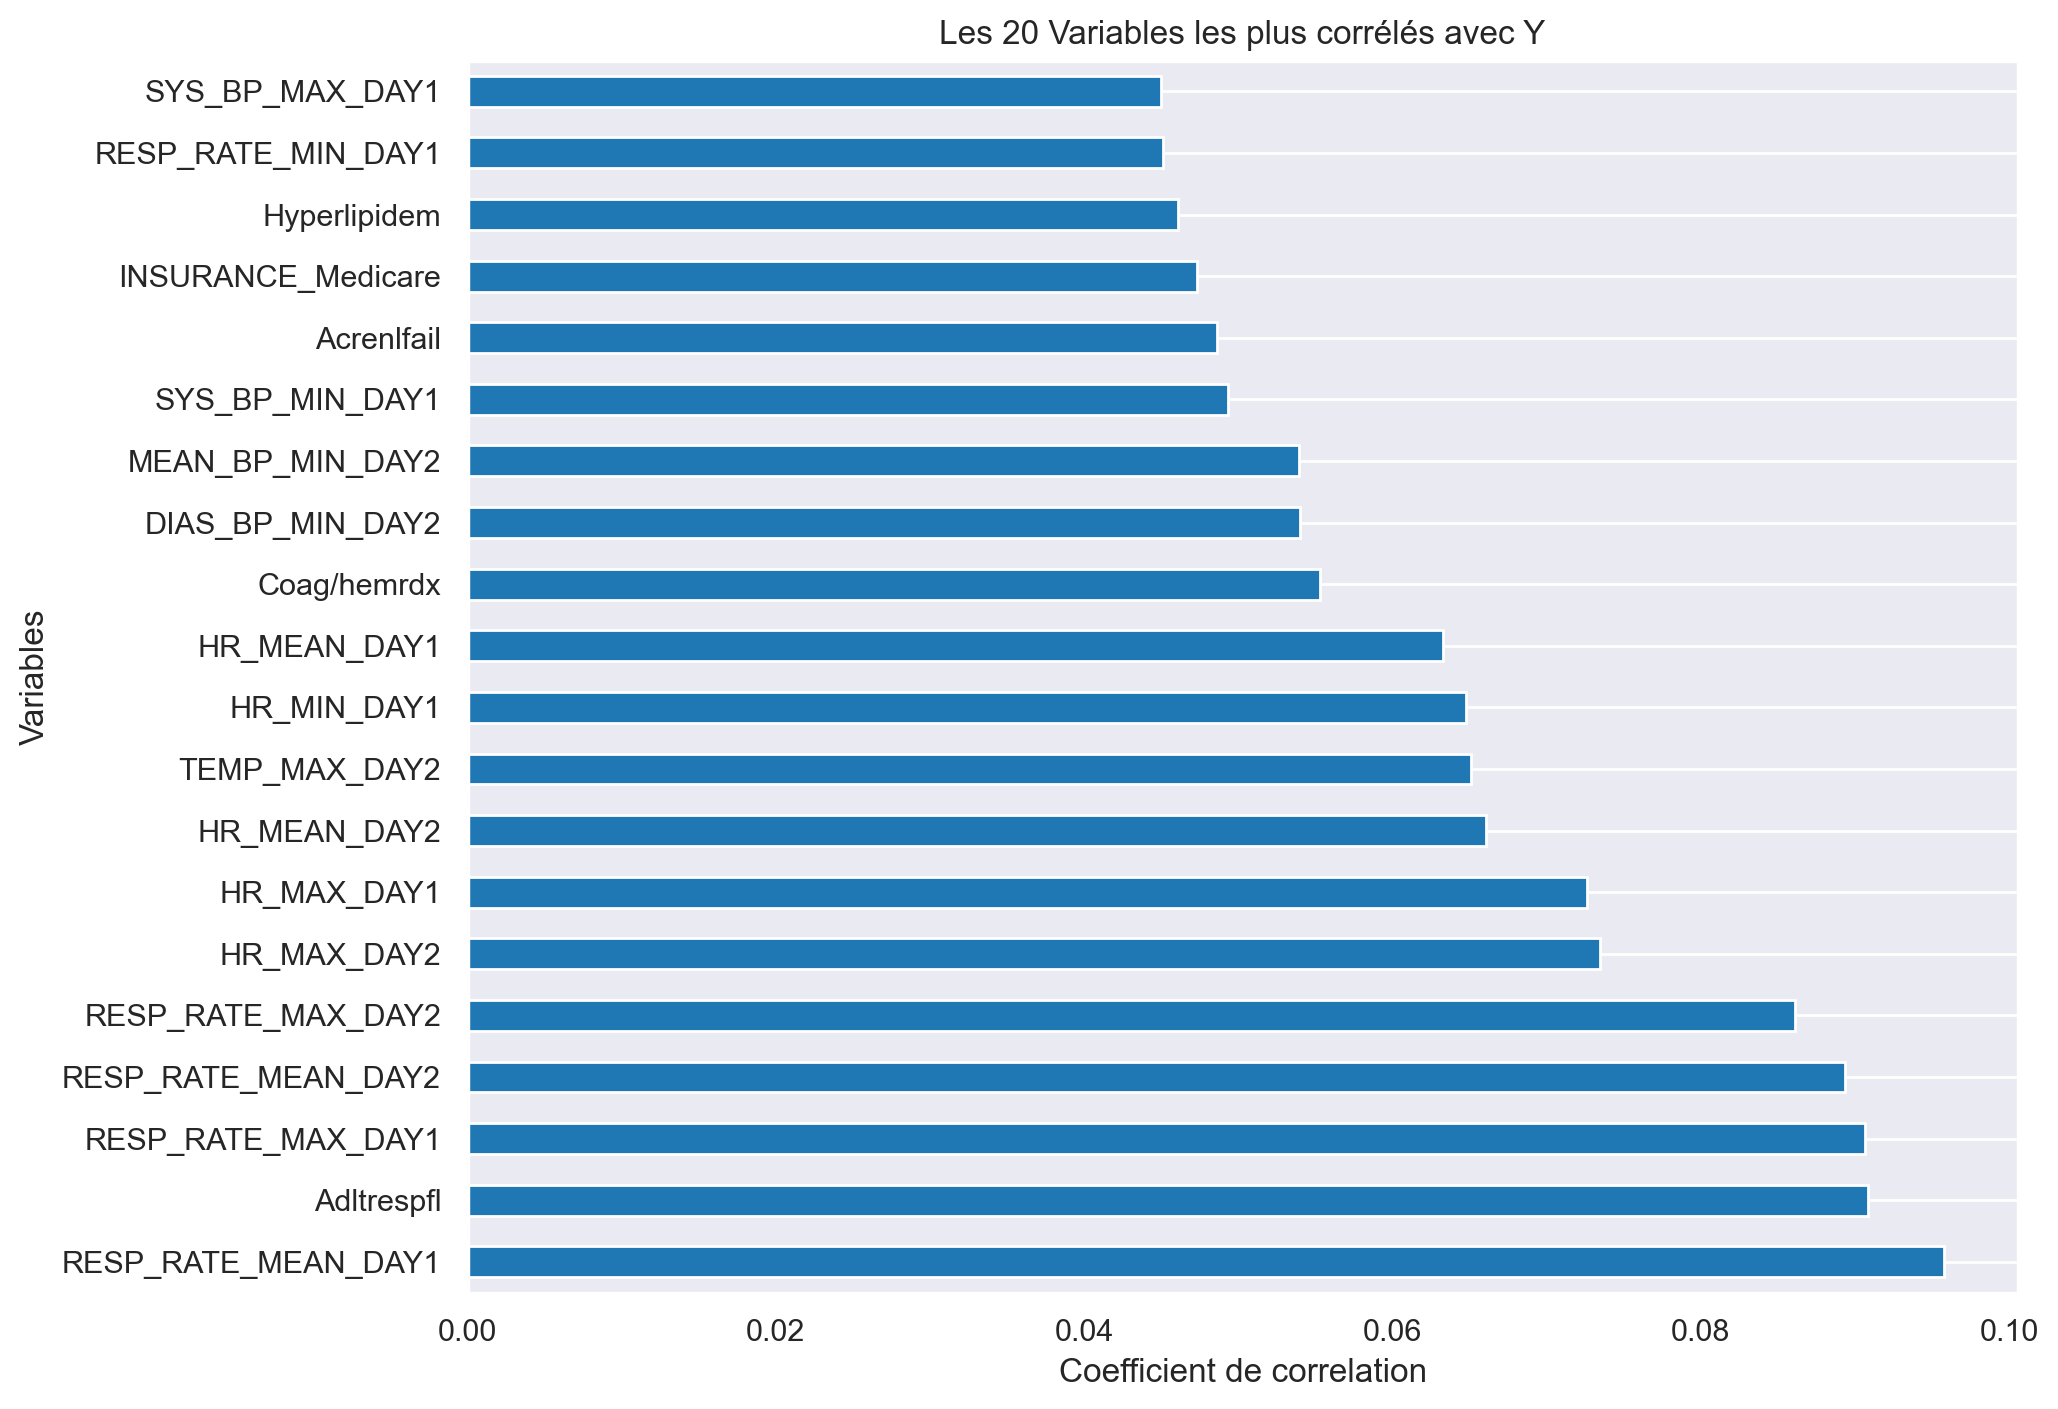

In [15]:
# Plot horizontal bar chart for correlations
plt.figure(figsize=(10, 8))
sorted_correlations.head(20).plot(kind='barh')
plt.title('Les 20 Variables les plus corrélés avec Y')
plt.xlabel('Coefficient de correlation')
plt.ylabel('Variables')
plt.grid(axis='x')  # Add grid only on x-axis
plt.show()


On peut voir les variables les plus corrélés avec Y positivement et negativement

#### Autres graphiques ou résultats d'une analyse exploratoire

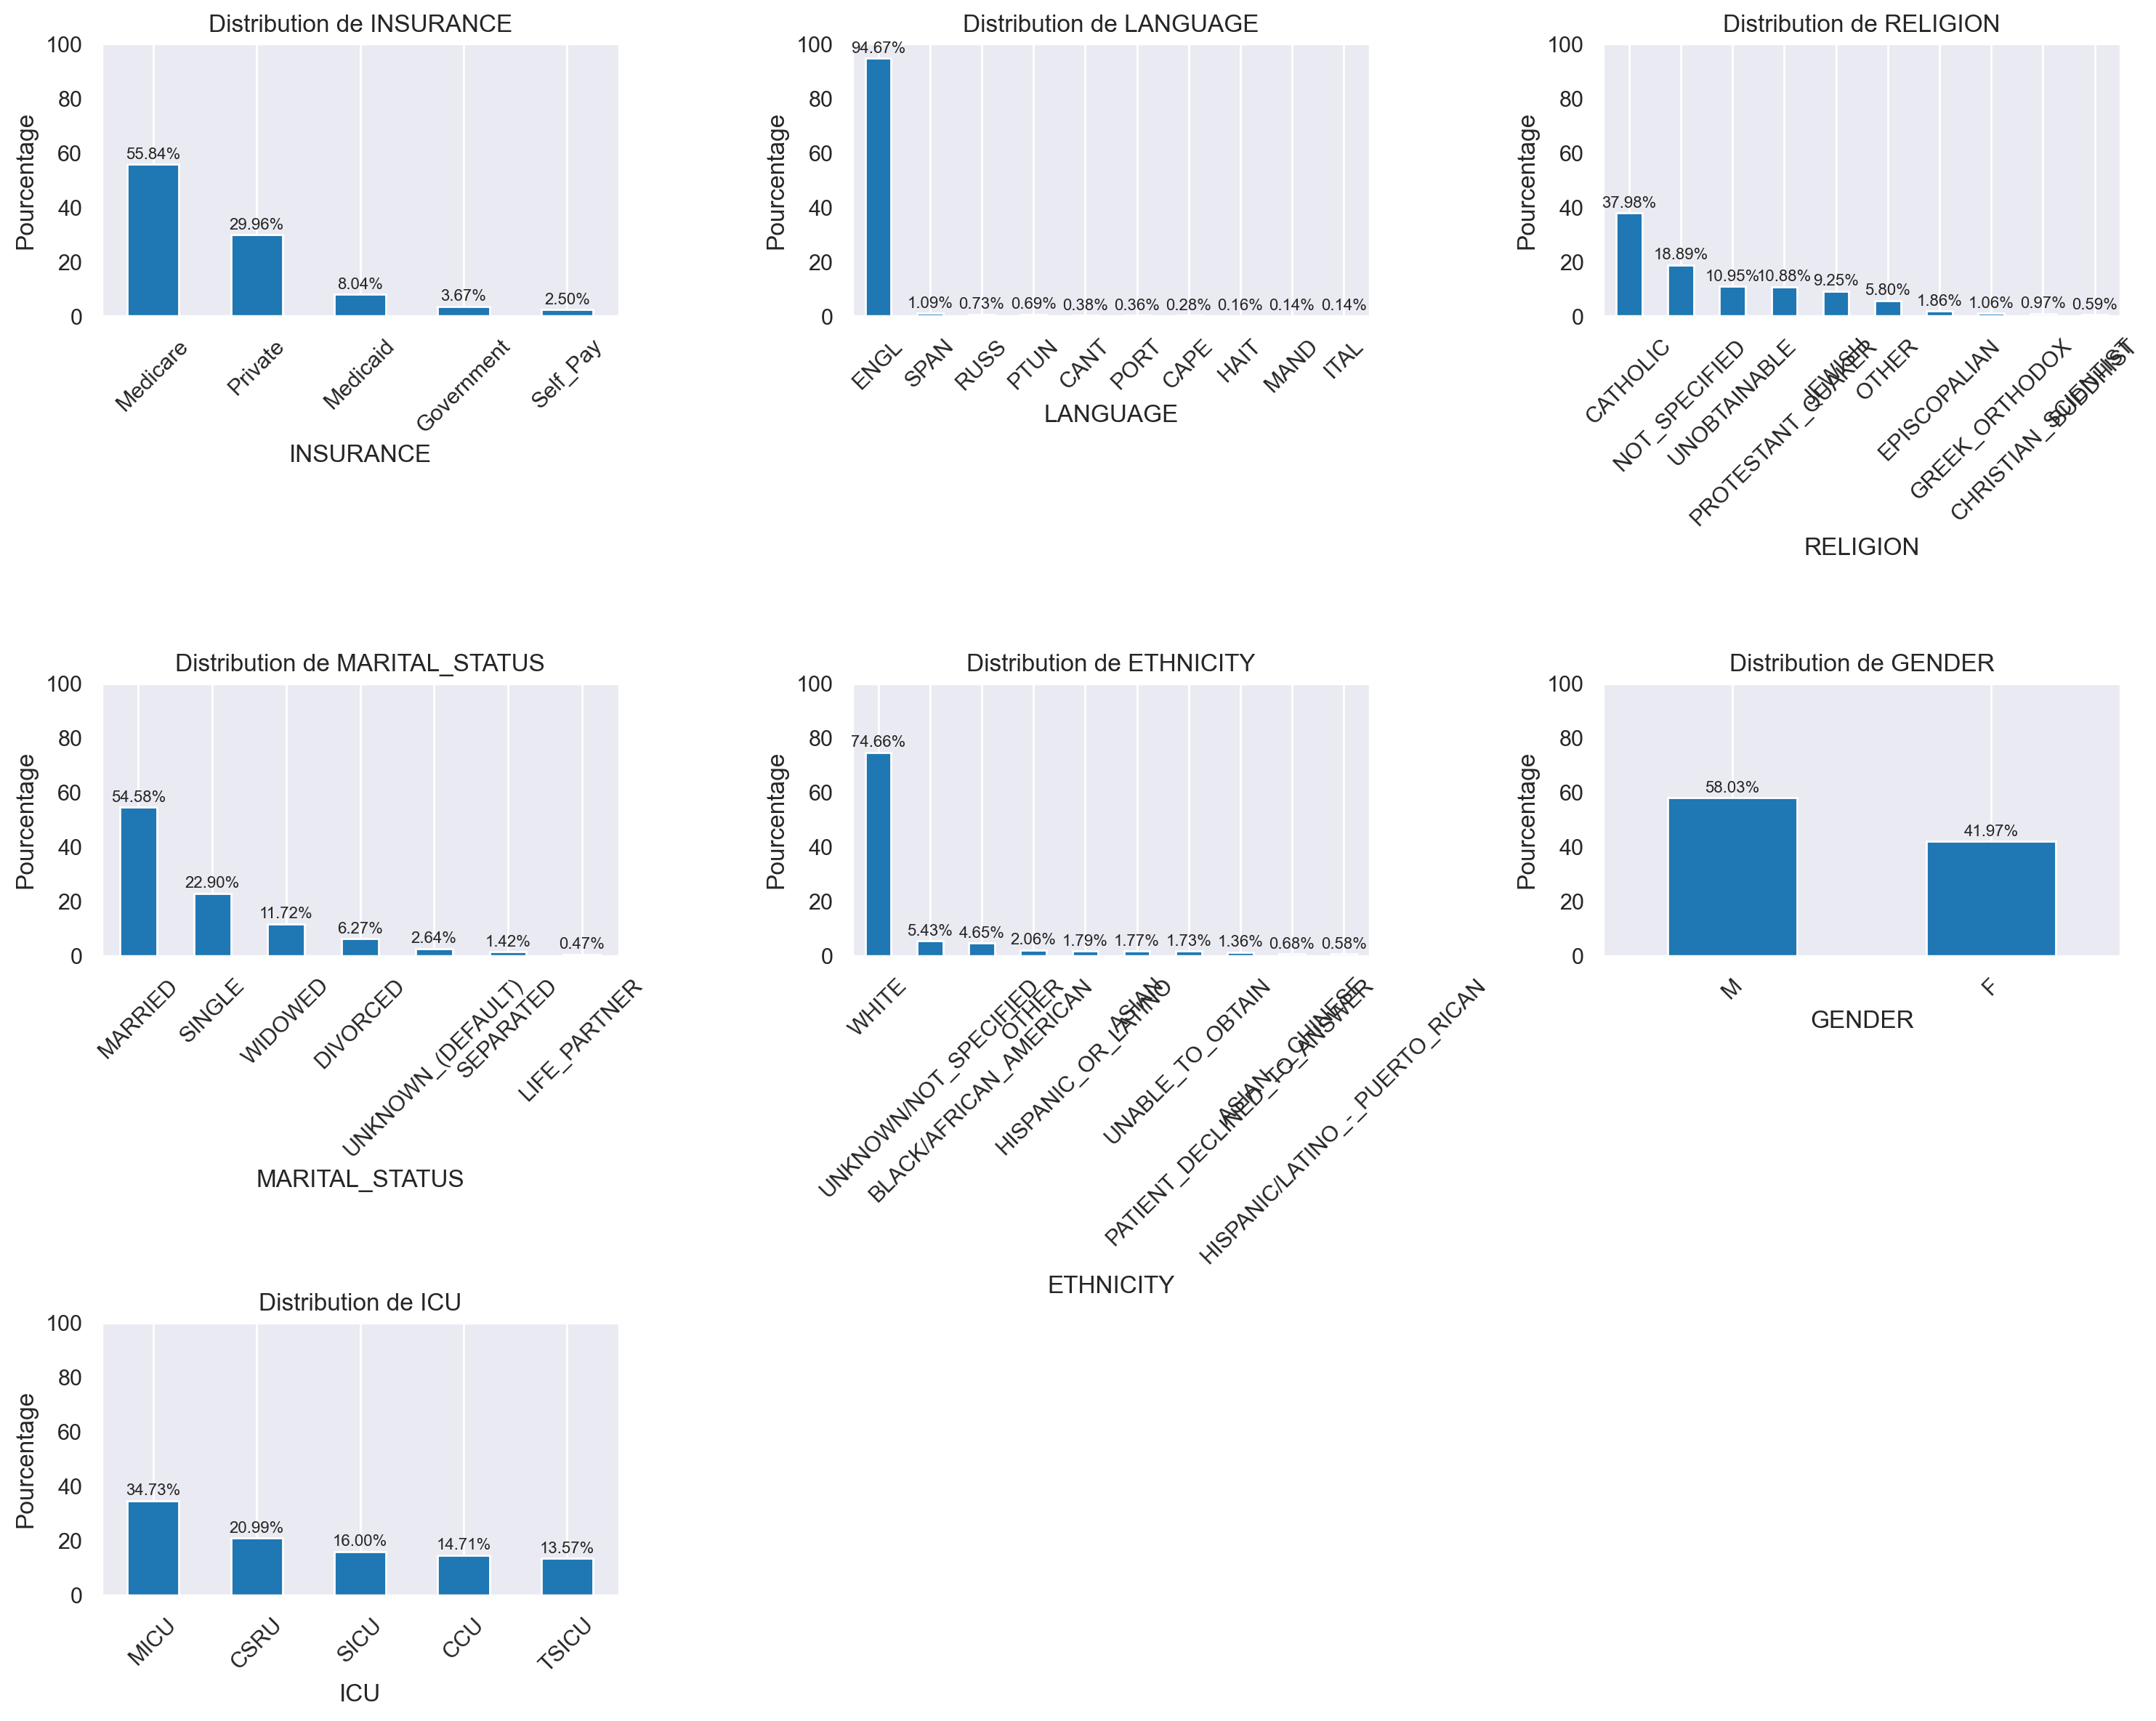

In [16]:
cat_features = x_df.select_dtypes(include=['object']).columns

plt.figure(figsize=(15, 12))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(3, 3, i)
    total_count = x_df[feature].count()
    value_counts = x_df[feature].value_counts() / total_count * 100  # Calculate percentage
    top_categories = value_counts.head(10)  # Select top 10 categories
    top_categories.plot(kind='bar')
    plt.title(f'Distribution de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Pourcentage')
    plt.ylim(0, 100)  # Set y-axis limit to percentage range
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(axis='y')  # Add horizontal gridlines
    for j, val in enumerate(top_categories):
        plt.text(j, val + 1, f"{val:.2f}%", ha='center', va='bottom', fontsize=8)  # Display percentage above bars
plt.tight_layout()
plt.show()


<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information.

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [17]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [18]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [19]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [20]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [21]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

/var/folders/k2/_thrpks545l5b45djnhfnbdw0000gn/T/ipykernel_65965/2545294214.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_df[col].fillna(x_df[col].mode()[0], inplace=True)
/var/folders/k2/_thrpks545l5b45djnhfnbdw0000gn/T/ipykernel_65965/2545294214.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [22]:
print(
    x_df.isna().any().any(),
    x_test_df.isna().any().any(),
    sep="\n",
)

False
False


In [23]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Gestion des catégories rares

Simplifiez les données en regroupant par exemple les catégories rares.

In [24]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object', name='RELIGION')
RELIGION
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: count, dtype: int64


In [25]:
for col in x_df.select_dtypes(include='object').columns:
    category_counts = x_df[col].value_counts(normalize=True)
    print(f"\n{col} category frequencies:")
    print(category_counts)

    # Identifier les catégories avec une fréquence inférieure à un certain seuil
    rare_categories = category_counts[category_counts < 0.05].index
    print(f"\n{col} rare categories:")
    print(rare_categories)


INSURANCE category frequencies:
INSURANCE
Medicare      0.558
Private         0.3
Medicaid     0.0804
Government   0.0367
Self_Pay      0.025
Name: proportion, dtype: float64

INSURANCE rare categories:
Index(['Government', 'Self_Pay'], dtype='object', name='INSURANCE')

LANGUAGE category frequencies:
LANGUAGE
ENGL      0.947
SPAN     0.0109
RUSS    0.00728
PTUN    0.00693
CANT    0.00383
         ...   
SERB      5e-05
*LIT      5e-05
*FAR   3.75e-05
*YID   3.75e-05
*PHI   3.75e-05
Name: proportion, Length: 68, dtype: float64

LANGUAGE rare categories:
Index(['SPAN', 'RUSS', 'PTUN', 'CANT', 'PORT', 'CAPE', 'HAIT', 'MAND', 'ITAL',
       'VIET', '*CRE', 'GREE', 'ARAB', 'POLI', 'CAMB', 'PERS', 'AMER', 'KORE',
       '**SH', 'HIND', 'ALBA', 'LAOT', '*_BE', 'ETHI', 'BENG', 'FREN', '*DEA',
       '*ARM', '*SPA', '*ARA', 'SOMA', 'JAPA', 'THAI', '*MAN', '*AMH', '*BEN',
       '*URD', '*GUJ', 'URDU', '*CAN', '*TAM', 'TURK', '*NEP', '*BUL', '*BOS',
       '*_FU', '*CHI', '*IBO', '*KHM', '*TOI

#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

<span style="color:red">
    Répondre ci-dessous
</span>

In [26]:
# Catégories rares identifiées pour chaque variable
categories_to_merge = {
    'INSURANCE': ['Government', 'Self_Pay'],
    'LANGUAGE': ['SPAN', 'RUSS', 'PTUN', 'CANT', 'PORT', 'HAIT', 'MAND', 'ITAL', 'VIET', 'GREE', 'ARAB', 'POLI', 'CAMB', 'PERS', 'AMER', 'KORE', 'HIND', 'ALBA', 'LAOT', 'ETHI', 'BENG', 'FREN', 'SOMA', 'JAPA', 'THAI', 'TURK', 'SERB', 'URDU', 'URD', 'TAM', 'BOS', 'BUL', 'YID', 'CDI', 'NEP', 'HUN', 'TOI', 'ROM', 'TEL', 'PHI', 'LIT', 'FAR'],
    'MARITAL_STATUS': ['UNKNOWN_(DEFAULT)', 'SEPARATED', 'LIFE_PARTNER'],
    'ETHNICITY': ['BLACK/AFRICAN_AMERICAN', 'OTHER', 'HISPANIC_OR_LATINO', 'ASIAN', 'UNABLE_TO_OBTAIN', 'PATIENT_DECLINED_TO_ANSWER', 'ASIAN_-_CHINESE', 'HISPANIC/LATINO_-_PUERTO_RICAN', 'BLACK/CAPE_VERDEAN', 'WHITE_-_RUSSIAN', 'MULTI_RACE_ETHNICITY', 'HISPANIC/LATINO_-_DOMINICAN', 'BLACK/HAITIAN', 'WHITE_-_OTHER_EUROPEAN', 'ASIAN_-_ASIAN_INDIAN', 'PORTUGUESE', 'WHITE_-_BRAZILIAN', 'ASIAN_-_VIETNAMESE', 'BLACK/AFRICAN', 'HISPANIC/LATINO_-_GUATEMALAN', 'AMERICAN_INDIAN/ALASKA_NATIVE', 'MIDDLE_EASTERN', 'WHITE_-_EASTERN_EUROPEAN', 'ASIAN_-_OTHER', 'HISPANIC/LATINO_-_CUBAN', 'ASIAN_-_FILIPINO', 'HISPANIC/LATINO_-_CENTRAL_AMERICAN_(OTHER)', 'ASIAN_-_KOREAN', 'NATIVE_HAWAIIAN_OR_OTHER_PACIFIC_ISLANDER', 'ASIAN_-_CAMBODIAN', 'HISPANIC/LATINO_-_MEXICAN', 'HISPANIC/LATINO_-_COLOMBIAN', 'SOUTH_AMERICAN', 'CARIBBEAN_ISLAND', 'ASIAN_-_JAPANESE', 'HISPANIC/LATINO_-_SALVADORAN', 'ASIAN_-_THAI', 'HISPANIC/LATINO_-_HONDURAN', 'AMERICAN_INDIAN/ALASKA_NATIVE_FEDERALLY_RECOGNIZED_TRIBE'],
    # Ajouter d'autres variables et leurs catégories rares si nécessaire
}

# Appliquer la fonction merge_rare_categories pour chaque variable avec les catégories rares
for col, rare_categories in categories_to_merge.items():
    merge_rare_categories([x_df, x_test_df], col=col, keeps=rare_categories)

# Vérifier les nouvelles valeurs de catégorie après regroupement
for col in categories_to_merge.keys():
    print(f"\n{col} value counts after merging rare categories:")
    print(x_test_df[col].value_counts())



INSURANCE value counts after merging rare categories:
INSURANCE
OTHER         18731
Government      721
Self_Pay        549
Name: count, dtype: int64

LANGUAGE value counts after merging rare categories:
LANGUAGE
OTHER    19046
SPAN       258
RUSS       151
PTUN       147
CANT        77
PORT        69
HAIT        41
MAND        26
ITAL        23
VIET        21
HIND        14
ARAB        14
GREE        13
POLI        11
AMER        11
PERS        10
ALBA         8
KORE         7
ETHI         7
BENG         7
CAMB         7
JAPA         6
THAI         6
TURK         5
FREN         4
LAOT         4
SOMA         4
URDU         3
SERB         1
Name: count, dtype: int64

MARITAL_STATUS value counts after merging rare categories:
MARITAL_STATUS
OTHER                19108
UNKNOWN_(DEFAULT)      497
SEPARATED              301
LIFE_PARTNER            95
Name: count, dtype: int64

ETHNICITY value counts after merging rare categories:
ETHNICITY
OTHER                                         16424

### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [27]:
def label_encode(df, other_df, only_binary=False):
    """
    Select categorical variables and encode them in integers.
    """
    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [28]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,OTHER,OTHER,CATHOLIC,OTHER,OTHER,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,OTHER,OTHER,UNOBTAINABLE,OTHER,OTHER,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,OTHER,SPAN,CATHOLIC,OTHER,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [30]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [31]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,1,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [32]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,1,0,5,0,0,0,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,0,2,0,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [33]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1h_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1h_df = x_all_1h_df.iloc[: len(x_df)].copy()
x_test_1h_df = x_all_1h_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 337) (20001, 337)
(79999, 417) (20001, 417)


#### Suppression des variables à valeur unique (constantes)

In [34]:
const_cols = {col for col in x_1h_df if len(x_1h_df[col].unique()) == 1}
len(const_cols)

173

In [35]:
x_1h_df.drop(const_cols, axis="columns", inplace=True)
x_test_1h_df.drop(const_cols, axis="columns", inplace=True)

print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 244) (20001, 244)


### Création de l'ensemble de validation

In [36]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1h_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1h_df

In [37]:
x_1h_df

,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,...,ETHNICITY_UNABLE_TO_OBTAIN,ETHNICITY_WHITE_-_BRAZILIAN,ETHNICITY_WHITE_-_EASTERN_EUROPEAN,ETHNICITY_WHITE_-_OTHER_EUROPEAN,ETHNICITY_WHITE_-_RUSSIAN,ICU_CCU,ICU_CSRU,ICU_MICU,ICU_SICU,ICU_TSICU
0,0,21,57.2,109,70.8,79.8,120,94.4,26.9,68.9,...,False,False,False,False,False,False,False,False,True,False
1,1,39,79.3,121,96.9,94,139,114,38.6,74.3,...,False,False,False,False,False,True,False,False,False,False
2,1,40,118,175,141,123,144,135,67.8,83.3,...,False,False,False,False,False,False,False,True,False,False
3,1,75,83.8,89.2,86.1,111,145,128,61.1,75.2,...,False,False,False,False,False,True,False,False,False,False
4,0,55,60.9,106,80.6,87.6,128,99.1,42.7,64,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,0,76,56,97.9,79.7,77.5,120,102,26.7,49.7,...,False,False,False,False,False,False,True,False,False,False
79995,0,38,55.1,86,67.6,83.1,175,119,40.4,79.4,...,False,False,False,False,False,False,False,False,False,True
79996,0,90,74.3,91.3,91.4,95.9,139,131,52.7,85.1,...,False,False,False,False,False,False,False,False,True,False
79997,1,57,79.3,129,98.7,108,142,132,57.1,77.4,...,False,False,False,False,False,False,False,False,False,True


### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

<span style="color:red">
    Répondre ci-dessous
</span>

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)


pca = PCA(n_components=0.95)
x_pca = pca.fit_transform(x_scaled)

print("Dimensions des données avant ACP:", x_df.shape)
print("Dimensions des données après ACP:", x_pca.shape)

print("Variance expliquée par chaque composante principale:", pca.explained_variance_ratio_)


Dimensions des données avant ACP: (79999, 337)
Dimensions des données après ACP: (55999, 194)
Variance expliquée par chaque composante principale: [0.039 0.029 0.023 0.015 0.014 0.013 0.011 0.01  0.009 0.009 0.008 0.008
 0.008 0.008 0.007 0.007 0.007 0.006 0.006 0.006 0.006 0.006 0.006 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0

Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

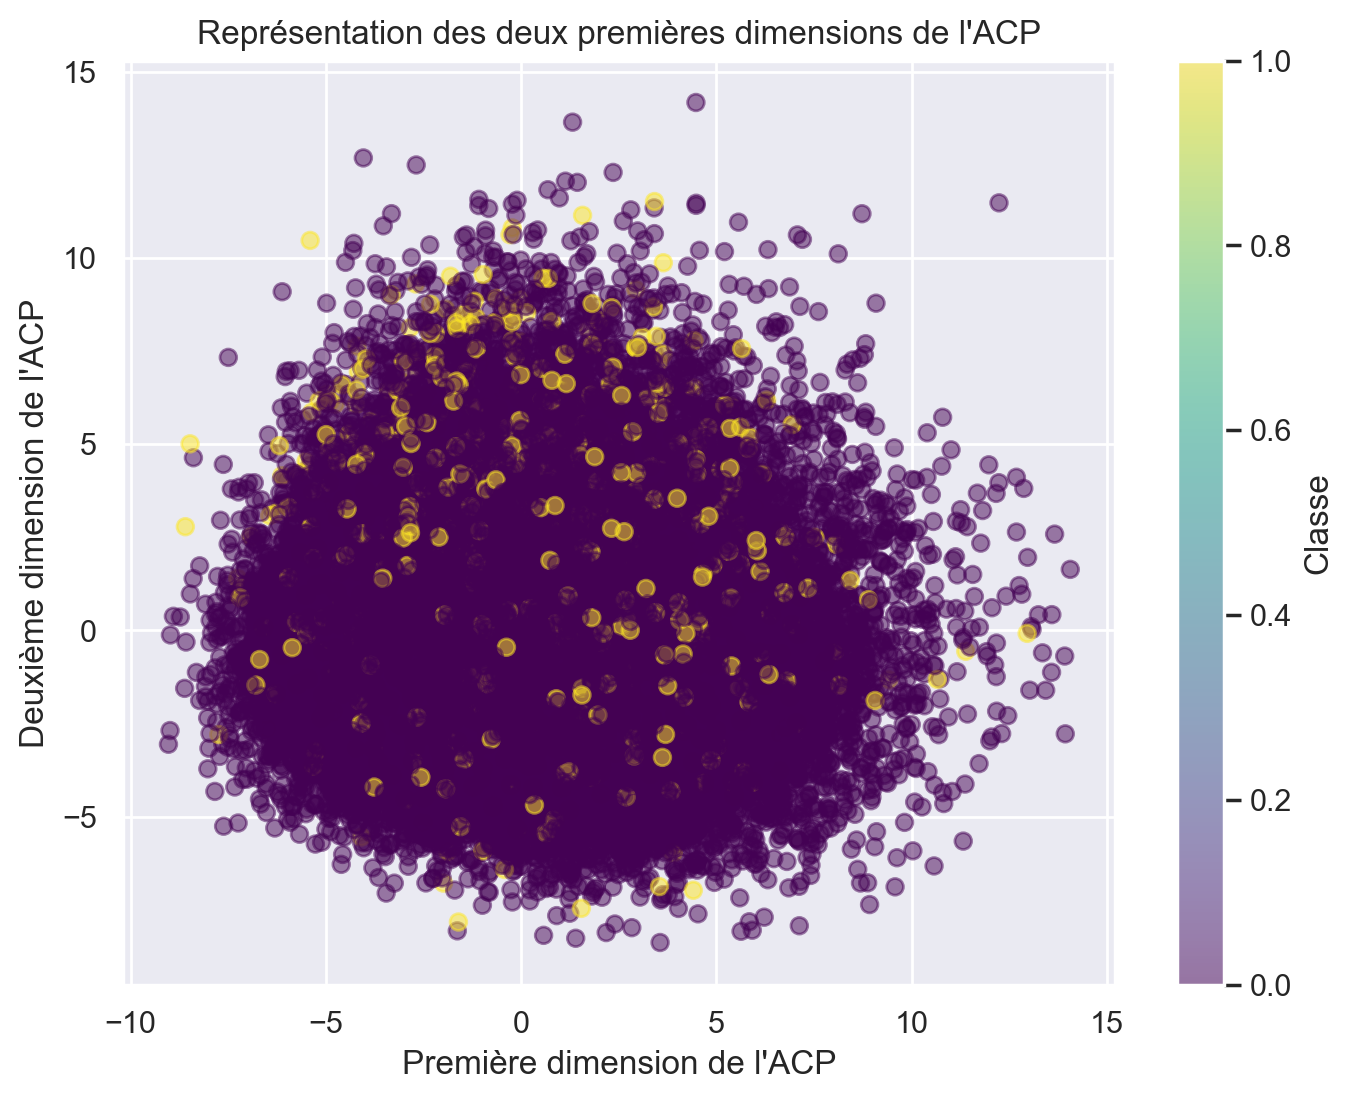

In [39]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.xlabel('Première dimension de l\'ACP')
plt.ylabel('Deuxième dimension de l\'ACP')
plt.title('Représentation des deux premières dimensions de l\'ACP')
plt.colorbar(label='Classe')
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [40]:
SCORINGS = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

logistic_model = LogisticRegression()
random_forest_model = RandomForestClassifier(n_estimators=10)

# Train Logistic Regression model
logistic_model.fit(x_train, y_train)

# Train Random Forest model
random_forest_model.fit(x_train, y_train)

# Predictions
logistic_preds = logistic_model.predict(x_valid)
random_forest_preds = random_forest_model.predict(x_valid)

/Users/bag/mambaforge/envs/isd2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 6. Évaluations

In [42]:
logistic_accuracy = balanced_accuracy_score(y_valid, logistic_preds)
random_forest_accuracy = balanced_accuracy_score(y_valid, random_forest_preds)

print("Logistic Regression Balanced Accuracy:", logistic_accuracy)
print("Random Forest Balanced Accuracy:", random_forest_accuracy)

Logistic Regression Balanced Accuracy: 0.5050997331978148
Random Forest Balanced Accuracy: 0.5005234404777029


### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [43]:
CV = 5

<span style="color:red">
    Répondre ci-dessous
</span>

In [51]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define a smaller parameters grid for RandomForestClassifier
param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5]
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='balanced_accuracy')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model using cross-validation
cross_val_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='balanced_accuracy')
mean_cross_val_score = cross_val_scores.mean()
std_cross_val_score = cross_val_scores.std()

print("Mean Cross-Validation Balanced Accuracy:", mean_cross_val_score)
print("Standard Deviation of Cross-Validation Balanced Accuracy:", std_cross_val_score)


Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 10}
Mean Cross-Validation Balanced Accuracy: 0.5001176558390992
Standard Deviation of Cross-Validation Balanced Accuracy: 0.0004926301445076851


In [45]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define a minimal parameters grid for RandomForestClassifier
param_grid = {
    'n_estimators': [10],
    'max_depth': [None],
    'min_samples_split': [2]
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='balanced_accuracy')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model using cross-validation
cross_val_scores = cross_val_score(best_model, x_train, y_train, cv=3, scoring='balanced_accuracy')
mean_cross_val_score = cross_val_scores.mean()
std_cross_val_score = cross_val_scores.std()

print("Mean Cross-Validation Balanced Accuracy:", mean_cross_val_score)
print("Standard Deviation of Cross-Validation Balanced Accuracy:", std_cross_val_score)


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}
Mean Cross-Validation Balanced Accuracy: 0.5006409112745125
Standard Deviation of Cross-Validation Balanced Accuracy: 0.0006291811765343057


ValueError: List of boxplot statistics and `positions` values must have same the length

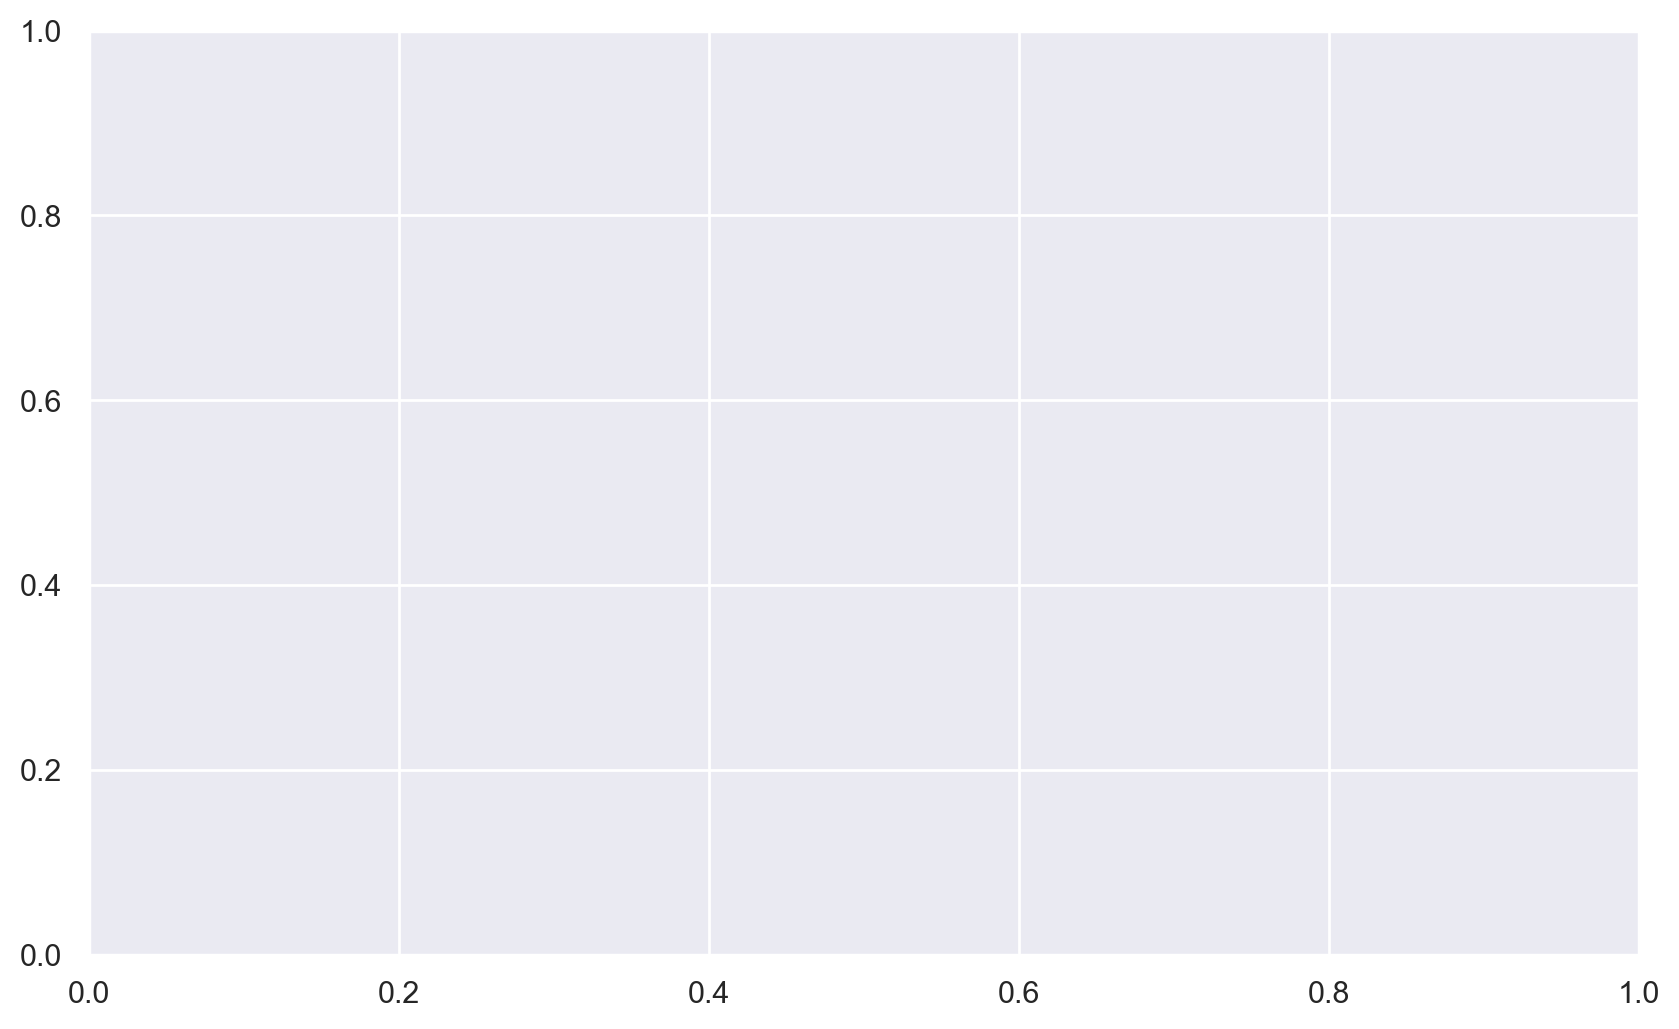

In [53]:
plt.figure(figsize=(10, 6))

for param, param_values in param_grid.items():
    param_scores = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['param_'+param] == param_values[0]]
    for value in param_values[1:]:
        param_scores = np.vstack([param_scores, grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['param_'+param] == value]])
    plt.boxplot(param_scores, positions=range(len(param_values)), widths=0.6, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    plt.xlabel(param)
    plt.ylabel('Balanced Accuracy')
    plt.title('Cross-Validation Scores for Different Hyperparameter Values (Logistic Regression)')

plt.xticks(range(len(param_values)), param_values)
plt.show()


# <span style="color:red">     Not working keeps loading
</span>

* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous.
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

In [55]:
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Define reduced parameters grid for LogisticRegression
logistic_param_grid = {
    'C': [0.1],
    'penalty': ['l2']
}

# Initialize LogisticRegression
logistic_model = LogisticRegression(max_iter=5000)

# Initialize GridSearchCV with reduced hyperparameter grid and fewer CV folds
logistic_grid_search = GridSearchCV(estimator=logistic_model, param_grid=logistic_param_grid, cv=5, scoring='balanced_accuracy')

# Fit the grid search to the data
logistic_grid_search.fit(x_train, y_train)

# Get the best parameters for Logistic Regression
best_logistic_params = logistic_grid_search.best_params_
print("Best Parameters for Logistic Regression:", best_logistic_params)

# Get the best Logistic Regression model
best_logistic_model = logistic_grid_search.best_estimator_

# Evaluate the best Logistic Regression model using cross-validation
logistic_cross_val_scores = cross_val_score(best_logistic_model, x_train, y_train, cv=5, scoring='balanced_accuracy')
mean_logistic_cross_val_score = logistic_cross_val_scores.mean()
std_logistic_cross_val_score = logistic_cross_val_scores.std()

print("Mean Cross-Validation Balanced Accuracy for Logistic Regression:", mean_logistic_cross_val_score)
print("Standard Deviation of Cross-Validation Balanced Accuracy for Logistic Regression:", std_logistic_cross_val_score)



/Users/bag/mambaforge/envs/isd2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bag/mambaforge/envs/isd2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Best Parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2'}


/Users/bag/mambaforge/envs/isd2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bag/mambaforge/envs/isd2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Mean Cross-Validation Balanced Accuracy for Logistic Regression: 0.5206344372857383
Standard Deviation of Cross-Validation Balanced Accuracy for Logistic Regression: 0.006377064907893751


/Users/bag/mambaforge/envs/isd2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define reduced parameters grid for GradientBoostingClassifier
gradient_boosting_param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.1]
}

# Initialize GradientBoostingClassifier
gradient_boosting_model = GradientBoostingClassifier()

# Initialize GridSearchCV with reduced hyperparameter grid and fewer CV folds
gradient_boosting_grid_search = GridSearchCV(estimator=gradient_boosting_model, param_grid=gradient_boosting_param_grid, cv=3, scoring='balanced_accuracy')

# Fit the grid search to the data
gradient_boosting_grid_search.fit(x_train, y_train)

# Get the best parameters for Gradient Boosting Classifier
best_gradient_boosting_params = gradient_boosting_grid_search.best_params_
print("\nBest Parameters for Gradient Boosting Classifier:", best_gradient_boosting_params)

# Get the best Gradient Boosting Classifier model
best_gradient_boosting_model = gradient_boosting_grid_search.best_estimator_

# Evaluate the best Gradient Boosting Classifier model using cross-validation
gradient_boosting_cross_val_scores = cross_val_score(best_gradient_boosting_model, x_train, y_train, cv=3, scoring='balanced_accuracy')
mean_gradient_boosting_cross_val_score = gradient_boosting_cross_val_scores.mean()
std_gradient_boosting_cross_val_score = gradient_boosting_cross_val_scores.std()

print("Mean Cross-Validation Balanced Accuracy for Gradient Boosting Classifier:", mean_gradient_boosting_cross_val_score)
print("Standard Deviation of Cross-Validation Balanced Accuracy for Gradient Boosting Classifier:", std_gradient_boosting_cross_val_score)



Best Parameters for Gradient Boosting Classifier: {'learning_rate': 0.1, 'n_estimators': 50}
Mean Cross-Validation Balanced Accuracy for Gradient Boosting Classifier: 0.5022627923287658
Standard Deviation of Cross-Validation Balanced Accuracy for Gradient Boosting Classifier: 0.0007501736474776989


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

# Initialize GradientBoostingClassifier
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)

# List of values for the hyperparameter to be tested
learning_rates = [0.01, 0.1, 0.5]

# Dictionary to store cross-validation scores for each value of the hyperparameter
cv_scores_dict = {'learning_rate': [], 'balanced_accuracy': []}

# Perform cross-validation for each value of the hyperparameter
for lr in learning_rates:
    gradient_boosting_model.learning_rate = lr
    cv_scores = cross_val_score(gradient_boosting_model, x_train, y_train, cv=5, scoring='balanced_accuracy')
    cv_scores_dict['learning_rate'].extend([lr] * len(cv_scores))
    cv_scores_dict['balanced_accuracy'].extend(cv_scores)

# Convert the dictionary to a pandas DataFrame
cv_scores_df = pd.DataFrame(cv_scores_dict)

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='learning_rate', y='balanced_accuracy', data=cv_scores_df)
plt.title('Variation de la balanced_accuracy moyenne selon le learning_rate (Gradient Boosting Classifier)')
plt.xlabel('Learning Rate')
plt.ylabel('Balanced Accuracy')
plt.show()


KeyboardInterrupt: 

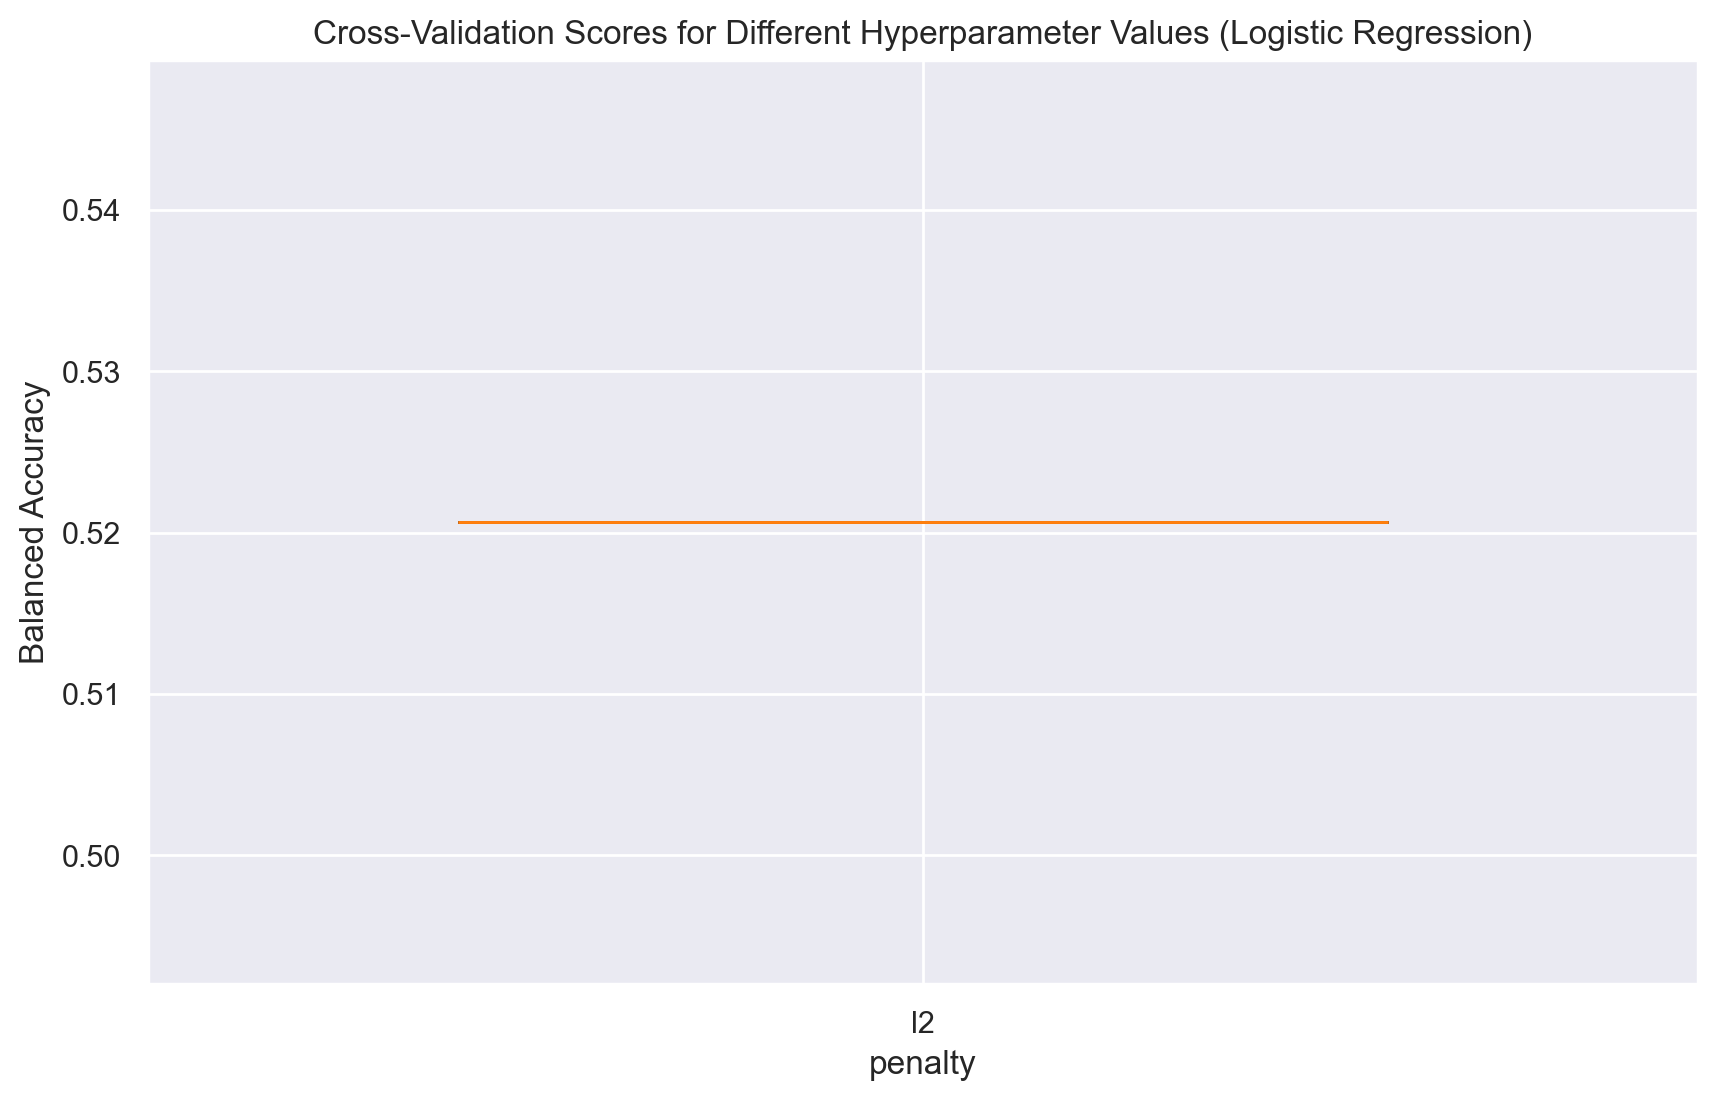

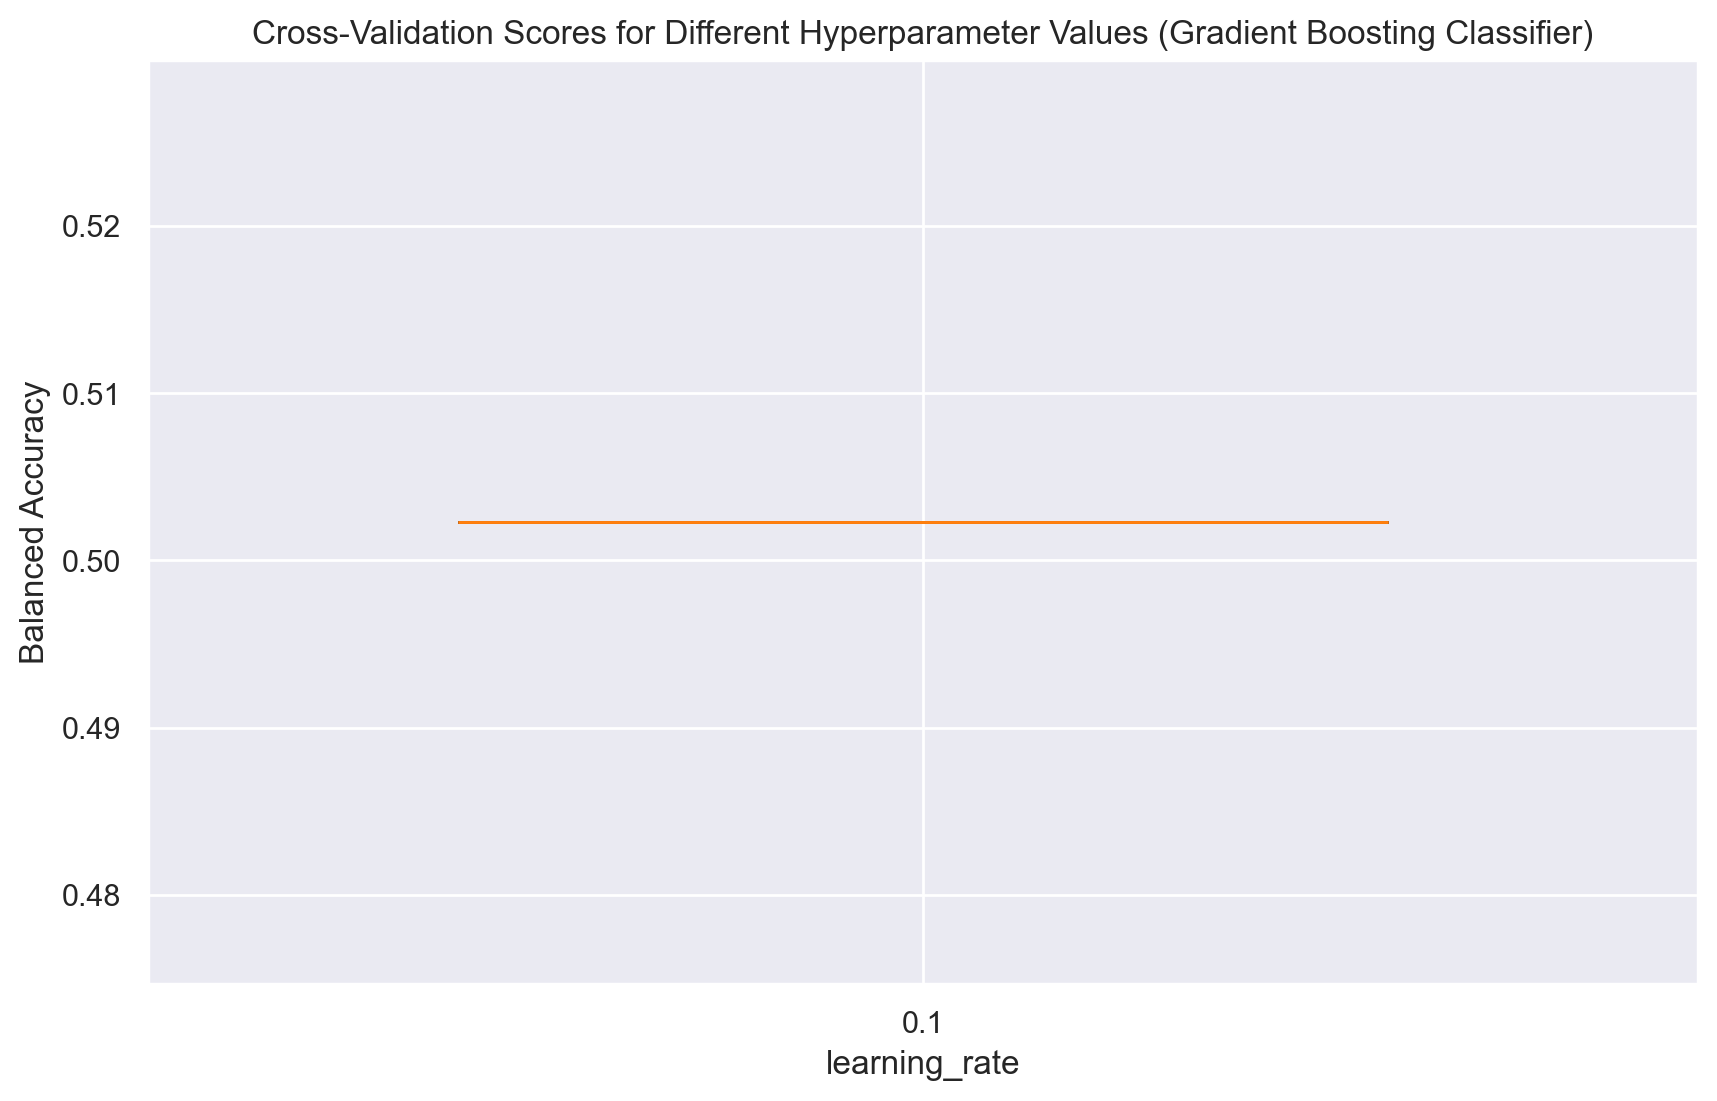

In [57]:

# Plot boxplots of cross-validation scores for different hyperparameter values for Logistic Regression
plt.figure(figsize=(10, 6))

for param, param_values in logistic_param_grid.items():
    param_scores = logistic_grid_search.cv_results_['mean_test_score'][logistic_grid_search.cv_results_['param_'+param] == param_values[0]]
    for value in param_values[1:]:
        param_scores = np.vstack([param_scores, logistic_grid_search.cv_results_['mean_test_score'][logistic_grid_search.cv_results_['param_'+param] == value]])
    plt.boxplot(param_scores, positions=range(len(param_values)), widths=0.6, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    plt.xlabel(param)
    plt.ylabel('Balanced Accuracy')
    plt.title('Cross-Validation Scores for Different Hyperparameter Values (Logistic Regression)')

plt.xticks(range(len(param_values)), param_values)
plt.show()

# Plot boxplots of cross-validation scores for different hyperparameter values for Gradient Boosting Classifier
plt.figure(figsize=(10, 6))

for param, param_values in gradient_boosting_param_grid.items():
    param_scores = gradient_boosting_grid_search.cv_results_['mean_test_score'][gradient_boosting_grid_search.cv_results_['param_'+param] == param_values[0]]
    for value in param_values[1:]:
        param_scores = np.vstack([param_scores, gradient_boosting_grid_search.cv_results_['mean_test_score'][gradient_boosting_grid_search.cv_results_['param_'+param] == value]])
    plt.boxplot(param_scores, positions=range(len(param_values)), widths=0.6, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.xlabel(param)
    plt.ylabel('Balanced Accuracy')
    plt.title('Cross-Validation Scores for Different Hyperparameter Values (Gradient Boosting Classifier)')

plt.xticks(range(len(param_values)), param_values)
plt.show()


<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
# TODO: Boxplot ou Barplot

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
from sklearn.metrics import roc_auc_score

# Utilisez le meilleur modèle de régression logistique trouvé précédemment
best_logistic_model = logistic_grid_search.best_estimator_

# Faites des prédictions sur les données de validation
y_pred_logistic = best_logistic_model.predict_proba(x_valid)[:, 1]

# Calculez l'aire sous la courbe ROC
auc_logistic = roc_auc_score(y_valid, y_pred_logistic)

print("AUC pour le modèle de régression logistique:", auc_logistic)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialisez le modèle GradientBoostingClassifier avec les meilleurs hyperparamètres trouvés précédemment
best_gb_model = GradientBoostingClassifier(**best_gradient_boosting_params)

# Entraînez le modèle sur les données d'entraînement
best_gb_model.fit(x_train, y_train)

# Faites des prédictions sur les données de validation
y_pred_gb = best_gb_model.predict_proba(x_valid)[:, 1]

# Calculez l'aire sous la courbe ROC
auc_gb = roc_auc_score(y_valid, y_pred_gb)

print("AUC pour le modèle GradientBoostingClassifier:", auc_gb)


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for Logistic Regression
confusion_mtx_lr = confusion_matrix(y_valid, y_pred_logistic.round())

# Confusion matrix for Gradient Boosting
confusion_mtx_gb = confusion_matrix(y_valid, y_pred_gb.round())

# Display the confusion matrix for Logistic Regression
print("Confusion Matrix for Logistic Regression:")
print(confusion_mtx_lr)

# Display the confusion matrix for Gradient Boosting
print("\nConfusion Matrix for Gradient Boosting:")
print(confusion_mtx_gb)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_proba = best_model.predict_proba(x_valid)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)

# Compute AUC score
auc_score = roc_auc_score(y_valid, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
# TODO: Data augmentation

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model),
    ]
)

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<span style="color:red">
    Répondre ci-dessous
</span>

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ?

* En quoi pourrait-il être utile dans ce problème ?

<span style="color:red">
    Répondre ci-dessous
</span>

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://www.codabench.org/competitions/2887/?secret_key=08892cca-646b-48a8-ad17-5b1a053c0ad0)
("My Submissions")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1h_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [ ]:
predictions = model.predict(x_test_1h_df)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1h_df, x_test_1h_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions/submission_2023-04-07T11-53-05.zip


---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---